# System of equations

This is the first attempt to account for surface processes in the H transport problem. The main idea is to introduce an additional type of H species, i.e. surface species (adsorbed H). To illustrate the possibility of implementing "surface processes" in FESTIM, let's consider a simple problem. Assuming an absense of trapping sites, the transport of H in the bulk can be described by:
$
\begin{gather}
\frac{\partial c_m}{\partial t} = D \frac{\partial^2 c_m}{\partial x^2} 
\end{gather}
$
with the initial value $c_m\vert_{t=0}=n_0$. The concentration of mobile H at the right boundary is fixed and also equal to $n_0$.

Evolutions of subsurface ($c_m\vert_{x=0}$) and surface ($c_s$) populations are governed by the flux balance according to the simplified potential diagram, shown below.

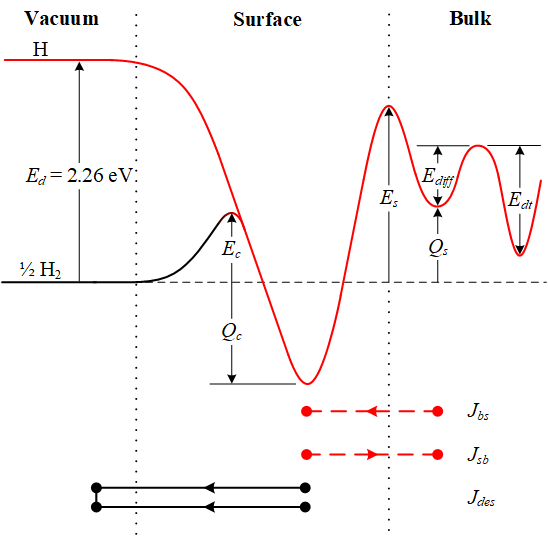

Only minor number of processes are considered: bulk-to-surface transition ($J_{bs}$), surface-to-bulk transition ($J_{sb}$), desorption from the surface ($J_{des}$). It worth noticing that more general models of the H transport including surface processes can be found elsewhere:

[1] Pisarev, A. A., & Ogorodnikova, O. V. (1997). Elementary processes near the interface between hydrogen gas and solid. Journal of nuclear materials, 248, 52-59.

[2] Guterl, J., Smirnov, R. D., & Snyder, P. (2019). Effects of surface processes on hydrogen outgassing from metal in desorption experiments. Nuclear Fusion, 59(9), 096042.

[3] Hodille, E. A., Založnik, A., Markelj, S., Schwarz-Selinger, T., Becquart, C. S., Bisson, R., & Grisolia, C. (2017). Simulations of atomic deuterium exposure in self-damaged tungsten. Nuclear Fusion, 57(5), 056002.

The evolutions of subsurface and surface populations are defined with:
$
\begin{gather}
\frac{\partial c_s}{\partial t} = J_{bs} - J_{sb} - J_{des};\\
\lambda \frac{\partial c_m}{\partial t}\vert_{x=0} = J_{sb} - J_{bs} + D\frac{\partial c_m}{\partial x}\vert_{x=0},
\end{gather}
$
where $\lambda$ is the jumping distance between two interstitial sites (or the characteristic distance between adsorption site and the stable intertistial site in the subsurface layer). For simplicity, the initial surface coverage is assumed to be zero and the time derivative in the LHS of eq. (3) is assumed to be small:
$
\begin{gather}
D\frac{\partial c_m}{\partial x}\vert_{x=0} = J_{bs} - J_{sb}.
\end{gather}
$ 
The rates of transitions are assumed to follow the Arrhenius law as follows:
$
\begin{gather}
J_{bs} = c_m \lambda\left(\frac{D(T)}{\lambda^2}\right) \cdot \left(1 - \frac{c_s}{s}\right);\\
J_{sb} = c_s\nu \exp\left[-\frac{E_s-Q_c}{k_BT}\right] \cdot \left(1 - \frac{c_m}{n_{IS}}\right);\\
J_{des} = 2\frac{c_s^2}{s}\nu\exp\left[-2\frac{E_c-Q_c}{k_BT}\right],
\end{gather}
$
where $s$ - surface concentration of adsorption sites, $n_{IS}$ - bulk concentration of interstitial sites, $E_c=0$ - chemisorption activation energy, $E_s$ - absorption activation energy, $Q_c$ - heat of chemisorption, $Q_s$ - heat of absorption. 

# Libraries

In [1]:
import fenics as f
import festim as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Parameters

In [2]:
# Parameters
nu0 = 1e13 #attempt frequency / s^-1
Q_c = 0.74 #heat of chemisorption / eV
Q_s = 1.04 #heat of solution / eV
n_W = 6.305e28 #concentration of interstitial sites / m^-3
n_0 = n_W * 0.01 #initial H concentration / m^-3
s_W = 1.26 * n_W ** (2/3) #concentration of adsorption sites / m^-2
lambda_W = 110e-12 #distance between TIS sites / m
cs_0 = 0 #initial concentration of H adatoms / m^-2
D_0 = 1.97e-7 #diffusivity prefactor / m^2/s
E_D = 0.2 #diffusivity exponent / eV
E_s = Q_s + E_D #activation energy for H solution / eV
L = 10e-6 #Geom. length / m

# Explicit

In [3]:
try:
    os.remove('explicit_out.txt')
    os.remove('explicit_des.txt')
except OSError:
    pass

def J_bs(T, mobile_conc, surf_conc):
    return (D_0 / lambda_W ** 2) * lambda_W * mobile_conc * f.exp(-E_D / F.k_B / T) * (1 - surf_conc / s_W)

def J_sb(T, mobile_conc, surf_conc):
    return nu0 * surf_conc * f.exp(-(E_s + Q_c) / F.k_B / T) * (1 - mobile_conc / n_W)

def flux_to_surf(T, mobile_conc, surf_conc):
    return -J_bs(T, mobile_conc, surf_conc) + J_sb(T, mobile_conc, surf_conc)

class CustomSimulation(F.Simulation):
    def iterate(self):
        super().iterate()
        # Surface concentration based on flux
        old_surf_conc = left_bc.prms['surf_conc']

        # Unnecessary export
        file = open("explicit_out.txt", "a")
        file.writelines(f"{self.t-float(self.dt.value)}\t{float(old_surf_conc)/s_W}\n")
        file.close()

        # FLuxes
        J_des = 2 * nu0 * old_surf_conc ** 2 / s_W * f.exp(-2 * Q_c / F.k_B / self.T.T(0))

        # Unnecessary export
        file = open("explicit_des.txt", "a")
        file.writelines(f"{self.t-float(self.dt.value)}\t{float(J_des)}\n")
        file.close()
        
        # Update surface concentration
        J_bs_val = J_bs(T=self.T.T(0), mobile_conc=self.mobile.solution(0), surf_conc=old_surf_conc)
        J_sb_val = J_sb(T=self.T.T(0), mobile_conc=self.mobile.solution(0), surf_conc=old_surf_conc)
        new_surf_conc = (
            old_surf_conc - (J_sb_val - J_bs_val + J_des) * self.dt.value
        )

        left_bc.prms['surf_conc'].assign(new_surf_conc)


my_model = CustomSimulation()
vertices = np.linspace(0, L, 2000)
my_model.mesh = F.MeshFromVertices(vertices)
my_model.materials = F.Material(
    id=1,
    D_0=D_0,
    E_D=E_D,
)

my_model.initial_conditions = [F.InitialCondition(field="solute", value=n_0)]

left_bc = F.CustomFlux(surfaces=1, field = 0, function = flux_to_surf, surf_conc = 0.0)
my_model.boundary_conditions = [
    left_bc,
    F.DirichletBC(field="solute", surfaces=2, value=n_0),
]

my_model.T = F.Temperature(1000)
my_model.settings = F.Settings(
    absolute_tolerance=1e-10,
    relative_tolerance=1e-10,
    final_time=1e-7,
)
my_model.dt = F.Stepsize(
    initial_value=1e-11,
)
my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
100.0 %        1.0e-07 s    Elapsed time so far: 47.1 s


# Implicit

In [4]:
try:
    os.remove('implicit_out.txt')
except OSError:
    pass

mesh = f.IntervalMesh(2000, 0, L)

class Left(f.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and f.near(x[0], 0)


class Right(f.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and f.near(x[0], L)


left = Left()
right = Right()
subdomains = f.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
subdomains.set_all(0)
left.mark(subdomains, 1)
right.mark(subdomains, 2)

ds = f.Measure("ds", domain=mesh, subdomain_data=subdomains)
# ---------- function space ----------------

CG1 = f.FiniteElement("CG", mesh.ufl_cell(), 1)
R = f.FiniteElement("R", mesh.ufl_cell(), 0)

element = f.MixedElement([CG1, R])

V = f.FunctionSpace(mesh, element)

u = f.Function(V)
u_n = f.Function(V)
v_c, v_cs = f.TestFunctions(V)

c, cs = f.split(u)
c_n, cs_n = f.split(u_n)

# ---------- initial conditions ----------------
c_initial = n_W * 0.01
f.assign(u.sub(0), f.interpolate(f.Constant(c_initial), V.sub(0).collapse()))
f.assign(u_n.sub(0), f.interpolate(f.Constant(c_initial), V.sub(0).collapse()))

cs_initial = 0.0
f.assign(u.sub(1), f.interpolate(f.Constant(cs_initial), V.sub(1).collapse()))
f.assign(u_n.sub(1), f.interpolate(f.Constant(cs_initial), V.sub(1).collapse()))
# ---------- fluxes ------------------------
T = 1000
D = D_0 * f.exp(-E_D / F.k_B / T)
J_bs = (D_0 / lambda_W ** 2) * lambda_W * c * f.exp(-E_D / F.k_B / T) * (1 - cs / s_W)
J_sb = nu0 * cs * f.exp(-(E_s + Q_c) / F.k_B / T) * (1 - c / n_W)
J_des = 2 * nu0 * cs ** 2 / s_W * f.exp(-2 * Q_c / F.k_B / T)
# ---------- variational form ----------------
dtt = 1e-11
dt = f.Constant(dtt)

Var = 0
Var += (c - c_n) / dt * v_c * f.dx
Var += D * f.inner(f.grad(c), f.grad(v_c)) * f.dx
Var += (J_bs - J_sb) * v_c * ds(1)

n = f.FacetNormal(mesh)
H_flux = D * f.inner(f.grad(c), n)

Var += (cs - cs_n) / dt * v_cs * ds(1)
Var += -(J_bs - J_sb) * v_cs * ds(1)
Var += J_des * v_cs * ds(1)

bcs = [
    f.DirichletBC(V.sub(0), c_initial, subdomains, 2),
]

# ---------- solve ----------------
cs_P = f.project(u.split()[1], V.sub(1).collapse())

file = open("implicit_out.txt", "a")
for i in range(10000):
    f.solve(Var == 0, u, bcs)

    u_n.assign(u)
    cs_P = f.project(u.split()[1], V.sub(1).collapse())

    file.writelines(f"{(i+1) * dtt}\t{cs_P.vector()[0]/s_W}\n")
file.close()


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


# Comp. plots

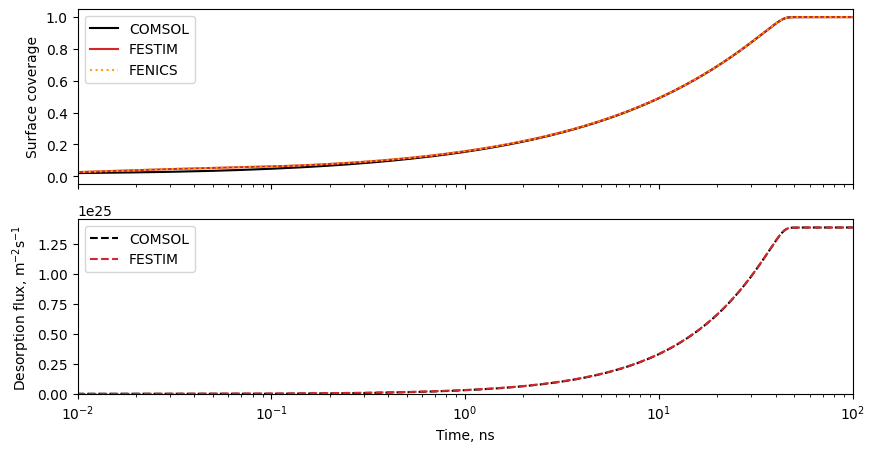

In [7]:
FESTIM_expl = pd.read_csv("explicit_out.txt", header = None, sep = "\\s+")
FESTIM_des_expl = pd.read_csv("explicit_des.txt", header = None, sep = "\\s+")
FESTIM_impl = pd.read_csv("implicit_out.txt", header = None, sep = "\\s+")
COMSOL_surf_cov = pd.read_csv("comsol_surf_cov.txt", header = None, sep = "\\s+")
COMSOL_des = pd.read_csv("comsol_des_flux.txt", header = None, sep = "\\s+")

fig, axs = plt.subplots(2, 1, figsize = (10, 5), sharex=True)

axs[0].plot(COMSOL_surf_cov[0], COMSOL_surf_cov[1], label = "COMSOL", ls = 'solid', color = 'black')
axs[0].plot(FESTIM_expl[0]/1e-9, FESTIM_expl[1], label = "FESTIM", ls = 'solid', color = 'tab:red')
axs[0].plot(FESTIM_impl[0]/1e-9, FESTIM_impl[1], label = "FENICS", ls = 'dotted', color = 'orange')

axs[1].plot(COMSOL_des[0], COMSOL_des[1], label = "COMSOL", ls = 'dashed', color = 'black')
axs[1].plot(FESTIM_des_expl[0]/1e-9, FESTIM_des_expl[1], label = "FESTIM", ls = 'dashed', color = 'tab:red')
axs[0].set_xscale('log')
axs[0].set_ylabel('Surface coverage')
axs[0].set_ylim(bottom=0)
axs[0].legend()
axs[1].legend()

axs[1].set_xlabel('Time, ns')
axs[1].set_xlim(1e-2, 1e2)
axs[1].set_ylabel(r'Desorption flux, m$^{-2}$s$^{-1}$')
axs[1].set_ylim(bottom=0)
plt.show()